In [1]:
import gentrl
import torch
import pickle
import pandas as pd
import numpy as np
from rdkit.Chem import Draw
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol
import matplotlib.pyplot as plt
import random
from utilities.config import Config

torch.cuda.set_device(0)

In [2]:
enc = gentrl.RNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)
model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

model.load('saved_gentrl_LA_after_rl/')
model.cuda();

In [3]:
def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])


def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [4]:
# def sampling(model, size=50, ):
#     batch_size = size
#     exploit_size = int(batch_size * (1 - 0.3))
#     exploit_z = model.lp.sample(exploit_size, 50 * ['s'] + ['m']) # [0.7*batch_size * 50]
#     # 50*['s']+['m']表示最后一位y是被marginalize了，其余全部sample
#     z_means = exploit_z.mean(dim=0) # [50]
#     z_stds = exploit_z.std(dim=0) # [50]
#     expl_size = int(batch_size * 0.3)
#     expl_z = torch.randn(expl_size, exploit_z.shape[1]) # [0.3*batch_size * 50]
#     # ε = μ+ N(sample) * σ
#     expl_z = 2 * expl_z.to(exploit_z.device) * z_stds[None, :] 
#     expl_z += z_means[None, :] # [0.3*batch_size * 50]
#     z = torch.cat([exploit_z, expl_z]) # [batch_size * 50]
#     smiles_list = model.dec.sample(batch_size, z, argmax=False)
#     return smiles_list

In [5]:
def sample_from_model(model, fps_som, size=1000, threshold = 0):
    generated = []

    while len(generated) < size:
        sampled = model.sample(size//10)
        sampled_valid = [s for s in sampled if get_mol(s) and len(s) > 10]
        generated += sampled_valid
        
    candi_smiles = []
    grades = []
    for s in generated:
        if fps_som.som_reward(s) >= threshold and s not in fps_som.smiles_set:
            grades.append(fps_som.som_reward(s))
            candi_smiles.append(s)
            
    idxs = np.argsort(grades).tolist()
    idxs = idxs[::-1]
    
    smiles_list = [candi_smiles[i] for i in idxs]
    grades_list = [grades[i] for i in idxs]
    
    return smiles_list, grades_list

In [6]:
config = Config(smiles_format=2, topn_fp_features=5, mode='threshold', max_fp_features=2048, threshold=0.3, morgan_radius=2)
with open(config.FpsSOM_model, 'rb') as infile:
    fps_som = pickle.load(infile)

In [7]:
smiles_list, grades_list = sample_from_model(model, fps_som)

RDKit ERROR: [19:42:22] SMILES Parse Error: ring closure 2 duplicates bond between atom 10 and atom 11 for input: 'CSc1ncc(C=C(C)C)c2c2ccn(CC(N)=O)sc12'
RDKit ERROR: [19:42:22] SMILES Parse Error: extra open parentheses for input: 'CCN(C(=O)NC(c1cccc(NC(C)(C)(=O)=O)C2CC2)c(F)c1'
RDKit ERROR: [19:42:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 13 22
RDKit ERROR: 
RDKit ERROR: [19:42:22] SMILES Parse Error: extra close parentheses while parsing: COc1ncc(Cc2ccccc2)nn1)c1cc(F)ccc1Cl
RDKit ERROR: [19:42:22] SMILES Parse Error: Failed parsing SMILES 'COc1ncc(Cc2ccccc2)nn1)c1cc(F)ccc1Cl' for input: 'COc1ncc(Cc2ccccc2)nn1)c1cc(F)ccc1Cl'
RDKit ERROR: [19:42:22] Can't kekulize mol.  Unkekulized atoms: 15
RDKit ERROR: 
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'CCN(C)c1cc(C)ccc1NC(=O)OC(C)S(=O)(=O)c1'
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1C(=O)NCCc2cnc3cc(C(F)(F)F)ccc21'
RDKit ERROR: [19:42:22] SMILES Parse Error: ring c

RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'COC(=O)c1cc(CN(C2(c3cccc(F)c3F)CO3)CC2)O1'
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'CC(C)Oc1cnc(C2CCN=C(N)=N)c1cnccn1'
RDKit ERROR: [19:42:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 18
RDKit ERROR: 
RDKit ERROR: [19:42:22] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [19:42:22] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(CN(C(=O)NCc2ccccc2)CC1'
RDKit ERROR: [19:42:22] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [19:42:22] SMILES Parse Error: extra close parentheses while parsing: Cc1ncc(C(C)N(C)C2CCCCC2)n2nc(C)c(C)c21)nc1
RDKit ERROR: [19:42:22] SMILES Parse Error: Failed parsing SMILES 'Cc1ncc(C(C)N(C)C2CCCCC2)n2nc(C)c(C)c21)nc1' for input: 'Cc1ncc(C(C)N(C)C2CCCCC2)n2nc(C)c(C)c21)nc1'
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'CN1CCOC(CO)C(=O)c1c(

RDKit ERROR: [19:42:22] SMILES Parse Error: extra close parentheses while parsing: Nc1cccc(-c2ccc(Cl)nn2)c1NC(C)=O)on1
RDKit ERROR: [19:42:22] SMILES Parse Error: Failed parsing SMILES 'Nc1cccc(-c2ccc(Cl)nn2)c1NC(C)=O)on1' for input: 'Nc1cccc(-c2ccc(Cl)nn2)c1NC(C)=O)on1'
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'CCc1ccc(SC(=O)N2CCCn3cccn3C2)ncnn12'
RDKit ERROR: [19:42:22] SMILES Parse Error: extra close parentheses while parsing: CN(C)C(=O)CC1C(=O)Nc1ccc(F)c(F)c1)NC1CCC1
RDKit ERROR: [19:42:22] SMILES Parse Error: Failed parsing SMILES 'CN(C)C(=O)CC1C(=O)Nc1ccc(F)c(F)c1)NC1CCC1' for input: 'CN(C)C(=O)CC1C(=O)Nc1ccc(F)c(F)c1)NC1CCC1'
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'CCc1csc(NC(=O)C2CCCN(S)c2ccccc2)n1'
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'NC1CC1c1ccccc1CN(CCO)C(=O)CO2'
RDKit ERROR: [19:42:22] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(OC)c1C(=O)N1CC2C(CO)Cn1ccnc1'
RDKit ERROR: [19

RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'CNc1ccc(C)cc1C1CC(=O)NC(C)Cn1ccnc1'
RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'CC(COCC(=O)c1csc2c(c1)CCOC2)ccc1O'
RDKit ERROR: [19:42:23] SMILES Parse Error: extra close parentheses while parsing: CC(C)Cc1cc(=O)c2cccc(OC)c2F)s1
RDKit ERROR: [19:42:23] SMILES Parse Error: Failed parsing SMILES 'CC(C)Cc1cc(=O)c2cccc(OC)c2F)s1' for input: 'CC(C)Cc1cc(=O)c2cccc(OC)c2F)s1'
RDKit ERROR: [19:42:23] SMILES Parse Error: extra open parentheses for input: 'Cc1cccn2c(nc1SC(C)C2=C2C(=O)O1'
RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'CC(C)n1cnc2c(c1=O)c2cccc(F)c2c1Cn1ccccc1C2=O'
RDKit ERROR: [19:42:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 22
RDKit ERROR: 
RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'COc1cc2ncccc2n1NC(CC2CC2)Sc2ccc(C)n12'
RDKit ERROR: [19:42:23] SMILES Parse Error: extra open parentheses for input: 'CCOC(=O)CC(c1cc(C)oc1-c1ccc(

RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'CCC(O)C1C(=O)NCC1(NC(=O)Cc2ccccc2Cl)CCO2'
RDKit ERROR: [19:42:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 18 19 20 21 22 23
RDKit ERROR: 
RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'CC1CC(NS(=O)(=O)C12CCc2ccc(F)cc2F)(F)(F)F'
RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'CC1CC(NC(=O)C2(CCCC2)COC2)cnn1'
RDKit ERROR: [19:42:23] Can't kekulize mol.  Unkekulized atoms: 14 15 16
RDKit ERROR: 
RDKit ERROR: [19:42:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 21
RDKit ERROR: 
RDKit ERROR: [19:42:23] SMILES Parse Error: extra open parentheses for input: 'CCCN(C(=O)c1cnc(C2CC=C)nc1-n1ccnc1'
RDKit ERROR: [19:42:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 18 19
RDKit ERROR: 
RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'CCC(C)n1ccc(Cn2cccc2-c2ccncc2)c2N1'
RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(CNC(

RDKit ERROR: [19:42:23] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-n2cc(CNS(=O)(=O)CCC#N)nc2n1)c(=O)[nH]1'
RDKit ERROR: [19:42:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 16 17 18 19 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:23] SMILES Parse Error: extra close parentheses while parsing: COC(=O)C(Nc1ncccn1)n1c(C)cccc1SC)C(=O)C
RDKit ERROR: [19:42:23] SMILES Parse Error: Failed parsing SMILES 'COC(=O)C(Nc1ncccn1)n1c(C)cccc1SC)C(=O)C' for input: 'COC(=O)C(Nc1ncccn1)n1c(C)cccc1SC)C(=O)C'
RDKit ERROR: [19:42:23] SMILES Parse Error: syntax error while parsing: COc1ccc(C23CCN(C(=O)c3ccccc3)CC2(C#N)C1=C)C1=
RDKit ERROR: [19:42:23] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C23CCN(C(=O)c3ccccc3)CC2(C#N)C1=C)C1=' for input: 'COc1ccc(C23CCN(C(=O)c3ccccc3)CC2(C#N)C1=C)C1='
RDKit ERROR: [19:42:23] SMILES Parse Error: extra close parentheses while parsing: CN(C)c1cc(C(F)(F)F)ccc2NCCN2CCOCC2)cc1
RDKit ERROR: [19:42:23] SMILES Parse Error: Failed parsing SMILES 'CN(C)c1cc(C(F)(F

RDKit ERROR: [19:42:24] SMILES Parse Error: extra close parentheses while parsing: CC(Oc1ccc(C#N)cc1)C(CN1CCCO1)c1ccccn1)C1CC1
RDKit ERROR: [19:42:24] SMILES Parse Error: Failed parsing SMILES 'CC(Oc1ccc(C#N)cc1)C(CN1CCCO1)c1ccccn1)C1CC1' for input: 'CC(Oc1ccc(C#N)cc1)C(CN1CCCO1)c1ccccn1)C1CC1'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 3 4 5
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: extra close parentheses while parsing: C#CC1COCCCNC(=O)c2cnccc2)c1
RDKit ERROR: [19:42:24] SMILES Parse Error: Failed parsing SMILES 'C#CC1COCCCNC(=O)c2cnccc2)c1' for input: 'C#CC1COCCCNC(=O)c2cnccc2)c1'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 3 4 6
RDKit ERROR: 
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 24 25
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: extra open parentheses for input: 'C(C(=O)c1nc2ccccc2n1)c1nc2c(cc1SCCO2'
RDKit ERROR: [19:42:24] SMILES Parse Error: extra close parentheses while par

RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'CSc1cc(CC2C(=O)NCc3cc(F)cc(C(F)(F)F)c2F)c1'
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C)c(C(O)CC2(O)C(O)c3ccccc3)c(C)o1'
RDKit ERROR: [19:42:24] SMILES Parse Error: extra open parentheses for input: 'CC(C)Oc1ccnc(CNC(=O)c1cn2cc(Cl)ccc12'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 15 16 17
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: extra open parentheses for input: 'CC(Sc1cc(C(=O)Nc2cccc(C#N)o2)ccc1F'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 17 18 19 20 21 22 23
RDKit ERROR: 
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 16
RDKit ERROR: 
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19 23 24
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: extra

RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'Cn1cc(C#CC2C(F)(F)F)c2ccc(N)cc2CN1CCOCC1'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 18 20
RDKit ERROR: 
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 13 14 15
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'CCc1ccc(C(=O)NCC(CO)C2CCCC3CO2)cn1'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 17
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C(O)Cc2ccsc2)N2CCOCCO1'
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'C1(C)COc2ccc(CSc3ccccc3)c(C#N)cc1'
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)C(Cc1ccc[nH]2)C(=O)c1c(C)cn1C'
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'C=C(C)CC1NC(=O)c1nc2c(cccc1n)CO1'
RDKit ERROR: [19:42:24] SMILES Parse Error: extra open parentheses for input: 'CN(C)c1cc

RDKit ERROR: [19:42:24] SMILES Parse Error: extra open parentheses for input: 'COCCCOc1ccc(C(=O)CCNc1cc(Cl)cc(OC)c1'
RDKit ERROR: [19:42:24] SMILES Parse Error: extra open parentheses for input: 'CC(C)Cc1csc(C2CN(C(C)(C)OC2)OC(C)O1'
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'NC(=O)c1cc(C(=O)N2CCCC2c2ccccc2OCC2)cc1'
RDKit ERROR: [19:42:24] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(NC(=O)CC(O)C2(c2ccc(F)cc2C)o1'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 22
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'COC(=O)C(N)c1cc(NCc(Br)c2)nc(N)c1'
RDKit ERROR: [19:42:24] Can't kekulize mol.  Unkekulized atoms: 4 5 6 14 15 16 17 19 20
RDKit ERROR: 
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'COC(=O)C1CC(c2ccccc2F)C(=O)N1CCOCC21'
RDKit ERROR: [19:42:24] SMILES Parse Error: unclosed ring for input: 'COc1nc(-c2cc(CCC3(N)NC(C)C)c(-c3ccco3)c2)o1'
RDKit ERROR: [19:42

RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'COc1ccc(-c2cnc(C#N)cc2)nc2c(OC(=O)c1ccn2C)no1'
RDKit ERROR: [19:42:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 17 18
RDKit ERROR: 
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'COC(C)c1ccc(CN2C(=O)c3ccccc3O2)C1CC1C'
RDKit ERROR: [19:42:25] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C)cc(OCC(=O)N(c2ccc(Br)cc2)CC1'
RDKit ERROR: [19:42:25] SMILES Parse Error: extra open parentheses for input: 'COc1cc(C(=O)NCC(C)(c2ccc(F)n(C)OC)o1'
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'CCC(NCc1cc(Br)c(C#N)cc1F)N1CCc2c1cnoc1C'
RDKit ERROR: [19:42:25] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 19 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'CCC(C)N1CCC(CC#N)C(=O)c1cscn(C)c1'
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'CS(=O)(=O)c1cc(NCn2ccnc2)ccc2c(=O)nccc1OC'
RDKit ERROR: [19:42:25] SM

RDKit ERROR: [19:42:25] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(Cl)cc1S(=O)(=O)N2c1ccc(Br)cc1F'
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'COC(C)(C)c1cc(CN2CC(CO)C(O)C2C2=O)c[nH]1'
RDKit ERROR: [19:42:25] SMILES Parse Error: extra close parentheses while parsing: CCCc1cscc1C(=O)NC(C)(C)c1ccccc1)(CC#N
RDKit ERROR: [19:42:25] SMILES Parse Error: Failed parsing SMILES 'CCCc1cscc1C(=O)NC(C)(C)c1ccccc1)(CC#N' for input: 'CCCc1cscc1C(=O)NC(C)(C)c1ccccc1)(CC#N'
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'COc1cccc(-c2ccc3n(s2)SC2CSCC2)n1'
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'COc1cc(-c2nnc(C3CCOc3ccccc3)n2)cc1'
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'c1cc(C)ccc1NC(=O)CC2Nnnc2sccc2n1'
RDKit ERROR: [19:42:25] SMILES Parse Error: extra close parentheses while parsing: CCS(=O)(=

RDKit ERROR: [19:42:25] SMILES Parse Error: extra close parentheses while parsing: C=CCN(CC)c1cc(C)c2c(n1)CCNC2=O)c(C(F)(F)F
RDKit ERROR: [19:42:25] SMILES Parse Error: Failed parsing SMILES 'C=CCN(CC)c1cc(C)c2c(n1)CCNC2=O)c(C(F)(F)F' for input: 'C=CCN(CC)c1cc(C)c2c(n1)CCNC2=O)c(C(F)(F)F'
RDKit ERROR: [19:42:25] SMILES Parse Error: ring closure 1 duplicates bond between atom 5 and atom 6 for input: 'O=C(COCC1c1cc(C#N)ccn1)C1c1cccnc1'
RDKit ERROR: [19:42:25] Can't kekulize mol.  Unkekulized atoms: 3 4 5
RDKit ERROR: 
RDKit ERROR: [19:42:25] SMILES Parse Error: extra close parentheses while parsing: CNC(=O)n1ncc1SC(c2ccc[nH]2)Cc2cccc3n2)n1
RDKit ERROR: [19:42:25] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)n1ncc1SC(c2ccc[nH]2)Cc2cccc3n2)n1' for input: 'CNC(=O)n1ncc1SC(c2ccc[nH]2)Cc2cccc3n2)n1'
RDKit ERROR: [19:42:25] SMILES Parse Error: unclosed ring for input: 'CNC(=O)CN1CC(NCc2ccc3c(c2)OCC(=O)C2)cn1'
RDKit ERROR: [19:42:25] SMILES Parse Error: extra open parentheses for input: 'C

RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'C1=C(C)c2nc(Sc3ccccc3F)nc2c1cccnc12'
RDKit ERROR: [19:42:26] SMILES Parse Error: extra close parentheses while parsing: COC(=O)CNC(=O)c1ccccc1C(=O)C2CCC1)c1ccc(C)cc1
RDKit ERROR: [19:42:26] SMILES Parse Error: Failed parsing SMILES 'COC(=O)CNC(=O)c1ccccc1C(=O)C2CCC1)c1ccc(C)cc1' for input: 'COC(=O)CNC(=O)c1ccccc1C(=O)C2CCC1)c1ccc(C)cc1'
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc3cccnc3nc2cc1)CN(C)C1=O'
RDKit ERROR: [19:42:26] SMILES Parse Error: extra close parentheses while parsing: CN(C)C(=O)COC(=O)c2ccco2)c2ccccc21
RDKit ERROR: [19:42:26] SMILES Parse Error: Failed parsing SMILES 'CN(C)C(=O)COC(=O)c2ccco2)c2ccccc21' for input: 'CN(C)C(=O)COC(=O)c2ccco2)c2ccccc21'
RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 7 8
RDKit ERROR: 
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'CC(C)c1cccnc1S(=O)(=O)C1CC1Cc2ccccc2s1'
RDKit ERROR: [19:

RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'CC(N)(C)C(=O)C1CC1(=O)OCC1(C)Cc1ccc(F)cc1C'
RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 19
RDKit ERROR: 
RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 21
RDKit ERROR: 
RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 2 3 7 8 9 21 22
RDKit ERROR: 
RDKit ERROR: [19:42:26] SMILES Parse Error: extra open parentheses for input: 'CC(=O)Nc1c(C(F)F)nc(OC2C=Cc2c1cccnc12'
RDKit ERROR: [19:42:26] SMILES Parse Error: extra close parentheses while parsing: CSc1ccccc1F)OCC(=O)Nc1nccc2c1CCC2
RDKit ERROR: [19:42:26] SMILES Parse Error: Failed parsing SMILES 'CSc1ccccc1F)OCC(=O)Nc1nccc2c1CCC2' for input: 'CSc1ccccc1F)OCC(=O)Nc1nccc2c1CCC2'
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'NC(=O)C1CN(Cc2ccccc2)CCc1ncc[nH]1'
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'COC(=O)Nc1cc(C(=O)NC2CCNC(=O)c2ccccc2)c(F)c1'
RDKit E

RDKit ERROR: [19:42:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C)ccc1NC(=O)CCc2ccsc2)nc1
RDKit ERROR: [19:42:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C)ccc1NC(=O)CCc2ccsc2)nc1' for input: 'Cc1cc(C)ccc1NC(=O)CCc2ccsc2)nc1'
RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 2 3 4
RDKit ERROR: 
RDKit ERROR: [19:42:26] SMILES Parse Error: extra open parentheses for input: 'CCC(=O)c1cn(C(=O)N(CCc2ccc[nH]c2=O)CC1'
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'CCn1cc(-c2c1ccn2C)ncc1SC(=O)c1cccnc1'
RDKit ERROR: [19:42:26] SMILES Parse Error: extra close parentheses while parsing: C(F)(O)CCNC(=O)c1cc(F)cn1)c1cccc(F)c1
RDKit ERROR: [19:42:26] SMILES Parse Error: Failed parsing SMILES 'C(F)(O)CCNC(=O)c1cc(F)cn1)c1cccc(F)c1' for input: 'C(F)(O)CCNC(=O)c1cc(F)cn1)c1cccc(F)c1'
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'Fc1cc2cnn(CCN3CCN(c3ncc(Br)cn3)CC2)c1C#N'
RDKit ERROR: [19:42:26] SMILES Parse Er

RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 18 19 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'NC(=O)CC1CCC(Nc1ccc(F)cc1)N1CCCC1'
RDKit ERROR: [19:42:26] SMILES Parse Error: extra close parentheses while parsing: CNC(=O)C1CC(=O)N(c2ccc(OC)c3c2)CCC2)C1
RDKit ERROR: [19:42:26] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1CC(=O)N(c2ccc(OC)c3c2)CCC2)C1' for input: 'CNC(=O)C1CC(=O)N(c2ccc(OC)c3c2)CCC2)C1'
RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [19:42:26] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(COCc2ccnc3n1-c1nc(C#N)cs1'
RDKit ERROR: [19:42:26] SMILES Parse Error: unclosed ring for input: 'CSc1ccc(C(F)(F)F)cc1C(=O)CCN1CC'
RDKit ERROR: [19:42:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5
RDKit ERROR: 
RDKit ERROR: [19:42:26] SMILES Parse Error: extra open parentheses for input: 'O=C(Nc1ccc2c(c1)OC

RDKit ERROR: [19:42:27] SMILES Parse Error: unclosed ring for input: 'CC(O)CN1CC(C)C(=O)N(Cc1ccc[nH]2)CC1'
RDKit ERROR: [19:42:27] SMILES Parse Error: unclosed ring for input: 'Cc1c(C)nccc1S(=O)(=O)N1CCSc1ccccc1'
RDKit ERROR: [19:42:27] SMILES Parse Error: unclosed ring for input: 'NC(=O)C1CC1NC(=O)N(Cc2nc3ccc(F)cc3[nH]2)CC1(C)C'
RDKit ERROR: [19:42:27] SMILES Parse Error: extra close parentheses while parsing: CC1CC(=O)NCCn2cccn2)c(OC2CCCCC2)C2=O)n1Cc1cccnc1
RDKit ERROR: [19:42:27] SMILES Parse Error: Failed parsing SMILES 'CC1CC(=O)NCCn2cccn2)c(OC2CCCCC2)C2=O)n1Cc1cccnc1' for input: 'CC1CC(=O)NCCn2cccn2)c(OC2CCCCC2)C2=O)n1Cc1cccnc1'
RDKit ERROR: [19:42:27] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 22
RDKit ERROR: 
RDKit ERROR: [19:42:27] Can't kekulize mol.  Unkekulized atoms: 4 5 6 16 18
RDKit ERROR: 
RDKit ERROR: [19:42:27] SMILES Parse Error: unclosed ring for input: 'CC(Cn1ccco1)Nc1ccc(F)cc1OCCCN1'
RDKit ERROR: [19:42:27] SMILES Parse Error: extra open parentheses for input

RDKit ERROR: [19:42:27] SMILES Parse Error: extra close parentheses while parsing: CNC(=O)C1CC(C)NC(=O)CC1c2ccccc2CC(N)=O)cc1
RDKit ERROR: [19:42:27] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1CC(C)NC(=O)CC1c2ccccc2CC(N)=O)cc1' for input: 'CNC(=O)C1CC(C)NC(=O)CC1c2ccccc2CC(N)=O)cc1'
RDKit ERROR: [19:42:27] SMILES Parse Error: unclosed ring for input: 'CC(=O)Nc1ccc(N2CCOCC2(S)CC2)c(Cl)c1'
RDKit ERROR: [19:42:27] SMILES Parse Error: extra close parentheses while parsing: CCOc1cc(C)nc(C2CC23CCOC2=O)c2cccnc2)n1
RDKit ERROR: [19:42:27] SMILES Parse Error: Failed parsing SMILES 'CCOc1cc(C)nc(C2CC23CCOC2=O)c2cccnc2)n1' for input: 'CCOc1cc(C)nc(C2CC23CCOC2=O)c2cccnc2)n1'
RDKit ERROR: [19:42:27] SMILES Parse Error: extra close parentheses while parsing: CC1C(=O)CN(C)c2ccccc2S1(=O)NCC#N)cc1Cl
RDKit ERROR: [19:42:27] SMILES Parse Error: Failed parsing SMILES 'CC1C(=O)CN(C)c2ccccc2S1(=O)NCC#N)cc1Cl' for input: 'CC1C(=O)CN(C)c2ccccc2S1(=O)NCC#N)cc1Cl'
RDKit ERROR: [19:42:27] SMILES Parse E

RDKit ERROR: [19:42:27] SMILES Parse Error: extra close parentheses while parsing: CS(=O)(=O)Nc1cccc(CNC(=O)C2CC2)c2ccccc2)c1
RDKit ERROR: [19:42:27] SMILES Parse Error: Failed parsing SMILES 'CS(=O)(=O)Nc1cccc(CNC(=O)C2CC2)c2ccccc2)c1' for input: 'CS(=O)(=O)Nc1cccc(CNC(=O)C2CC2)c2ccccc2)c1'
RDKit ERROR: [19:42:27] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 19
RDKit ERROR: 
RDKit ERROR: [19:42:27] SMILES Parse Error: syntax error while parsing: CCS(==C(=O)NC(C)c1ccc(Cl)cc1)c1ccccc1
RDKit ERROR: [19:42:27] SMILES Parse Error: Failed parsing SMILES 'CCS(==C(=O)NC(C)c1ccc(Cl)cc1)c1ccccc1' for input: 'CCS(==C(=O)NC(C)c1ccc(Cl)cc1)c1ccccc1'
RDKit ERROR: [19:42:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 19 20
RDKit ERROR: 
RDKit ERROR: [19:42:27] SMILES Parse Error: extra open parentheses for input: 'CC(=O)Nc1nc(C2NC(C)c2ccc3onc(C)c2c1=O'
RDKit ERROR: [19:42:27] SMILES Parse Error: unclosed ring for input: 'CC1(C)Cc2ccc(CN2CCCCNC(=O)C2(C)C)cn1'
RDKit ERROR: [19:42:27] SMILES Pars

RDKit ERROR: [19:42:28] SMILES Parse Error: extra close parentheses while parsing: CC(=O)Oc1cc(CCN2CC(O)C2)c2ccco2)cc1
RDKit ERROR: [19:42:28] SMILES Parse Error: Failed parsing SMILES 'CC(=O)Oc1cc(CCN2CC(O)C2)c2ccco2)cc1' for input: 'CC(=O)Oc1cc(CCN2CC(O)C2)c2ccco2)cc1'
RDKit ERROR: [19:42:28] SMILES Parse Error: extra close parentheses while parsing: CCc1ccc(C(F)(F)F)cc1N1CC(=O)C2CC1c2ccccc1)ccc1O
RDKit ERROR: [19:42:28] SMILES Parse Error: Failed parsing SMILES 'CCc1ccc(C(F)(F)F)cc1N1CC(=O)C2CC1c2ccccc1)ccc1O' for input: 'CCc1ccc(C(F)(F)F)cc1N1CC(=O)C2CC1c2ccccc1)ccc1O'
RDKit ERROR: [19:42:28] SMILES Parse Error: extra close parentheses while parsing: COC(=O)c1cccc(CC(=O)Nn2cnnn2)c1-n2ccnc2)c1
RDKit ERROR: [19:42:28] SMILES Parse Error: Failed parsing SMILES 'COC(=O)c1cccc(CC(=O)Nn2cnnn2)c1-n2ccnc2)c1' for input: 'COC(=O)c1cccc(CC(=O)Nn2cnnn2)c1-n2ccnc2)c1'
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1cccs1)C1CCC(=C(N)=O)C1Cc2cc(C3CC3)no1'
RDKit ERROR

RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'COc1cc(C)c(OCC(=O)N(C)C)ccn12'
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 5 6 7 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:28] SMILES Parse Error: extra close parentheses while parsing: NC(=O)c1ccnc(Sc2ccccc2C#N)cc1)Cc1ccccc1
RDKit ERROR: [19:42:28] SMILES Parse Error: Failed parsing SMILES 'NC(=O)c1ccnc(Sc2ccccc2C#N)cc1)Cc1ccccc1' for input: 'NC(=O)c1ccnc(Sc2ccccc2C#N)cc1)Cc1ccccc1'
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4
RDKit ERROR: 
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 25
RDKit ERROR: 
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'COc1cccc(C(=O)NC2COc3ccccc3Cl)c1OC(F)F'
RDKit ERROR: [19:42:28] SMILES Parse Error: extra open parentheses for input: 'Cc1occ(C(=O)NC2CCS(n2ccc3c(F)ccc23)C(F)F'
RDKit ERROR: [19:42:28] SMIL

RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'CC(C)(CNC(=O)C1CC2(CC2)CC2CC1)c1ccccc1C'
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'CCOc1ccnc(OCC)cc1-c1cc(C(N)CC)cc12'
RDKit ERROR: [19:42:28] SMILES Parse Error: ring closure 2 duplicates bond between atom 17 and atom 18 for input: 'CNc1cccc(-c2ncccc2NC(=O)CC2c2ccccc2)oc1C'
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13
RDKit ERROR: 
RDKit ERROR: [19:42:28] SMILES Parse Error: extra close parentheses while parsing: Cc1ncc(C)cc1Cn1ccc(CNc2nccnc2)c1C#N)c1
RDKit ERROR: [19:42:28] SMILES Parse Error: Failed parsing SMILES 'Cc1ncc(C)cc1Cn1ccc(CNc2nccnc2)c1C#N)c1' for input: 'Cc1ncc(C)cc1Cn1ccc(CNc2nccnc2)c1C#N)c1'
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C)c(C(=O)CC2C(=O)OCC3CCCO3)c(OC)c1'
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'NC(=O)C(c2cccc(Cl)c2C(=O)NC2CCCO2)cn1'
RDKit ERROR: [19:42:28] Can't kek

RDKit ERROR: [19:42:28] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(C(N)C(=O)NCC1CCC2OCC(F)CC1'
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 12 14 15
RDKit ERROR: 
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'CN(Cc1ccccc1)C1CCN(c2ccc(C)cc2)C(C)=O'
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 17 18
RDKit ERROR: 
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(Br)c(C(=O)N=C2CC2CC2)c1'
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'CN(C(=O)Cc1nc(N)cc2c1cc(Br)cn1)c1ccc(N)cc1'
RDKit ERROR: [19:42:28] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 20
RDKit ERROR: 
RDKit ERROR: [19:42:28] SMILES Parse Error: unclosed ring for input: 'CC1C(=O)Oc2ccc(CNC(=O)CCc2ncc(C)s2)cs1'
RDKit ERROR: [19:42:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 18 20 21
RDKit ERROR:

RDKit ERROR: [19:42:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 18
RDKit ERROR: 
RDKit ERROR: [19:42:29] SMILES Parse Error: unclosed ring for input: 'O=C(NCCc1ccc2cc(O)ccc21)CC1'
RDKit ERROR: [19:42:29] SMILES Parse Error: unclosed ring for input: 'NC(=O)Cc1ccc2ccc(NC(=O)C2CC3)cc2c1'
RDKit ERROR: [19:42:29] SMILES Parse Error: unclosed ring for input: 'NC1CCc2ccccc2N1CCCN(c2nnc3ccc(F)n3)CC1'
RDKit ERROR: [19:42:29] Can't kekulize mol.  Unkekulized atoms: 4 5 6 25 26
RDKit ERROR: 
RDKit ERROR: [19:42:29] SMILES Parse Error: unclosed ring for input: 'NC(C)1CCc2cc(C3=C(C#N)Cc3cccs3)cn21'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra open parentheses for input: 'COC(=O)c1ccc(NC(C(=O)N2CCc3c(nnc3C3)C2)[nH]nn1'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra open parentheses for input: 'Cn1c(C(=O)N=c2c[nH]nc2C(=O)OCc1ccc(F)cc1'
RDKit ERROR: [19:42:29] SMILES Parse Error: unclosed ring for input: 'CN(C)c1ncccc1C(=O)Nc1ccc2c(c1)CCC(C)C2CC1'
RDKit ERROR: [19:42:29] SMILES Parse E

RDKit ERROR: [19:42:29] SMILES Parse Error: extra open parentheses for input: 'N#CC1(NS(=O)(=O)c2ccc(CN3CCc3ccccc3)c2N1'
RDKit ERROR: [19:42:29] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 15
RDKit ERROR: 
RDKit ERROR: [19:42:29] SMILES Parse Error: extra close parentheses while parsing: CC(C)NC(=O)NC(C)Cc1ccsc1)C1CCCO1
RDKit ERROR: [19:42:29] SMILES Parse Error: Failed parsing SMILES 'CC(C)NC(=O)NC(C)Cc1ccsc1)C1CCCO1' for input: 'CC(C)NC(=O)NC(C)Cc1ccsc1)C1CCCO1'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra open parentheses for input: 'Cn1cc[nH]c1-c1ccc(N2CCN(Cc2ccsc2)CCC2'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(=O)nc(CC(=O)NCc1sc(C)[nH]c1C'
RDKit ERROR: [19:42:29] SMILES Parse Error: unclosed ring for input: 'Cc1c(-c2ccc3c(n2)CCN(C)CC3=O)c1ccc2oncc12'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra close parentheses while parsing: CC(=O)Nc1cc(C(=O)CS(=O)(=O)N(C)C)cc2)c(C)c1C
RDKit ERROR: [19:42:29] SMILES Parse Error: Failed

RDKit ERROR: [19:42:29] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(CC(C)CN2C(C)(C(N)=O)C2C2(C)C2'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra close parentheses while parsing: CC(C)OC1CCCC1)C(=O)CNc1ccc(Cl)cc1C#N
RDKit ERROR: [19:42:29] SMILES Parse Error: Failed parsing SMILES 'CC(C)OC1CCCC1)C(=O)CNc1ccc(Cl)cc1C#N' for input: 'CC(C)OC1CCCC1)C(=O)CNc1ccc(Cl)cc1C#N'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra close parentheses while parsing: FC(F)(F)C1CCC(=O)N1CC1CC1)c1ccc(C2nccc21
RDKit ERROR: [19:42:29] SMILES Parse Error: Failed parsing SMILES 'FC(F)(F)C1CCC(=O)N1CC1CC1)c1ccc(C2nccc21' for input: 'FC(F)(F)C1CCC(=O)N1CC1CC1)c1ccc(C2nccc21'
RDKit ERROR: [19:42:29] SMILES Parse Error: unclosed ring for input: 'Cc1ncsc1C(C)N(C)c1cc2scnc2c1CCOC2'
RDKit ERROR: [19:42:29] SMILES Parse Error: extra close parentheses while parsing: CC(O)(=O)C(C)N(C)c1ccc(Cl)cc1)C(C)c1cccs1
RDKit ERROR: [19:42:29] SMILES Parse Error: Failed parsing SMILES 'CC(O)(=O)C(C)N(C)c1ccc(C

RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'NC(=O)c1cc(S(=O)(=O)N1CCc2ccc(Cl)cc2)c[nH]1'
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'COC(CC(=O)NC1Cc2ccccc2C1)OCC1'
RDKit ERROR: [19:42:30] SMILES Parse Error: extra open parentheses for input: 'Nc1nc(C(NC(=O)C2CC3(CC2)CCO2)c1cnc(F)c(F)c21'
RDKit ERROR: [19:42:30] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [19:42:30] SMILES Parse Error: extra close parentheses while parsing: COc1ccccc1C(=O)Nc2ccc3c(c2)COCO3)cs1
RDKit ERROR: [19:42:30] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc1C(=O)Nc2ccc3c(c2)COCO3)cs1' for input: 'COc1ccccc1C(=O)Nc2ccc3c(c2)COCO3)cs1'
RDKit ERROR: [19:42:30] SMILES Parse Error: extra open parentheses for input: 'CSc1cccc(CN2CCN(C(=O)C2COc3ccccc32)CC1'
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'CCn1cnc(NC(=O)CC2OCc3ccccc3Cl)c(C)o1'
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'N

RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 19
RDKit ERROR: 
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'COC1CCC(c2ccnc(S(=O)(=O)C2Cc3cccc(F)c3)o2)C'
RDKit ERROR: [19:42:30] SMILES Parse Error: extra close parentheses while parsing: CC(=O)N(C)c1nc(-c2ccc(C)o2)csc1=O)c1ccco1
RDKit ERROR: [19:42:30] SMILES Parse Error: Failed parsing SMILES 'CC(=O)N(C)c1nc(-c2ccc(C)o2)csc1=O)c1ccco1' for input: 'CC(=O)N(C)c1nc(-c2ccc(C)o2)csc1=O)c1ccco1'
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'CC(=O)Nc1c(C(C)C)nc(CNc2nccs3)cc1O'
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'COCc1cc2ccccc2c(NCCCO)c12'
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 15 16
RDKit ERROR: 
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 5 6 8 23 24
RDKit ERROR: 
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C)nc(CN(C)C(=O)c2sccc2NC1=O)c1Cc1ccccc1'
RDKit 

RDKit ERROR: [19:42:30] SMILES Parse Error: extra close parentheses while parsing: CC(C)C1CC(O)(n2cc(Cl)ccn2)c2c(Br)cncc12)C
RDKit ERROR: [19:42:30] SMILES Parse Error: Failed parsing SMILES 'CC(C)C1CC(O)(n2cc(Cl)ccn2)c2c(Br)cncc12)C' for input: 'CC(C)C1CC(O)(n2cc(Cl)ccn2)c2c(Br)cncc12)C'
RDKit ERROR: [19:42:30] SMILES Parse Error: extra close parentheses while parsing: C=CSc1ccc(S=O)n2nc(NC(F)F)c3c2cc2cccnc23)cc1
RDKit ERROR: [19:42:30] SMILES Parse Error: Failed parsing SMILES 'C=CSc1ccc(S=O)n2nc(NC(F)F)c3c2cc2cccnc23)cc1' for input: 'C=CSc1ccc(S=O)n2nc(NC(F)F)c3c2cc2cccnc23)cc1'
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 20
RDKit ERROR: 
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'COc1cc(COC(=O)c3ccccc32)sc1Br'
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 5 6 7 10
RDKit ERROR: 
RDKit ERROR: [19:42:30] SMILES Parse Err

RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 5 6 7 16 17 19 20
RDKit ERROR: 
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 7
RDKit ERROR: 
RDKit ERROR: [19:42:30] SMILES Parse Error: extra close parentheses while parsing: CCS(=O)(=O)N2CCC(c3ccncn3)n2N)ccn1OC
RDKit ERROR: [19:42:30] SMILES Parse Error: Failed parsing SMILES 'CCS(=O)(=O)N2CCC(c3ccncn3)n2N)ccn1OC' for input: 'CCS(=O)(=O)N2CCC(c3ccncn3)n2N)ccn1OC'
RDKit ERROR: [19:42:30] SMILES Parse Error: unclosed ring for input: 'CC1CC(=O)NCC2C(=O)CC(c2ccccc2)O1'
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19
RDKit ERROR: 
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
RDKit ERROR: 
RDKit ERROR: [19:42:30] Can't kekulize mol.  Unkekulized atoms: 5 6 7 22 23
RDKit ERROR: 
RDKit ERROR: [19:42:30] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccncc2)cc(CO)c2ccccc2C)c1
RDKit ERROR: [19:42:30] SMILES Parse Error: Failed par

RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 5 6 7 19 21
RDKit ERROR: 
RDKit ERROR: [19:42:31] SMILES Parse Error: unclosed ring for input: 'Cc1cc(CC(=O)C2CC(=O)N=c2[nH]ccc2C)CC1'
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 18 19
RDKit ERROR: 
RDKit ERROR: [19:42:31] SMILES Parse Error: extra open parentheses for input: 'COc1c(C(C)(C)C#C(OC(=O)c2cc(C#N)ccc2C)co1'
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 4 5 7 19
RDKit ERROR: 
RDKit ERROR: [19:42:31] SMILES Parse Error: extra close parentheses while parsing: CC(=O)Oc1ccc(C#N)c(NCCO)c2cccs2)c1
RDKit ERROR: [19:42:31] SMILES Parse Error: Failed parsing SMILES 'CC(=O)Oc1ccc(C#N)c(NCCO)c2cccs2)c1' for input: 'CC(=O)Oc1ccc(C#N)c(NCCO)c2cccs2)c1'
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 3 18 20 21 22 23 25
RDKit ERROR: 
RDKit ERROR: [19:42:31] SMILES Parse Error:

RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 13 14 23 24
RDKit ERROR: 
RDKit ERROR: [19:42:31] SMILES Parse Error: unclosed ring for input: 'COc1cccc(C)c1COC(=O)c1cn[nH]c1-c1cccc2c1OC'
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 20
RDKit ERROR: 
RDKit ERROR: [19:42:31] SMILES Parse Error: extra open parentheses for input: 'CC1(C)COC(CN(c2ccc(F)c(F)c2F)C2CCC(C2)O1'
RDKit ERROR: [19:42:31] SMILES Parse Error: unclosed ring for input: 'Cc1nc(C(C)SCc2nccn2C(F)F)nc2c1'
RDKit ERROR: [19:42:31] SMILES Parse Error: extra open parentheses for input: 'CN(c1cc(COC(=O)C2(c3cccnc3)=NC2CC2)nn1'
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 16 17 18
RDKit ERROR: 
RDKit ERROR: [19:42:31] SMILES Parse Error: unclosed ring for input: 'CC(C)C1NC(=O)Nc2cccc(F)c2C#N'
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 1 2 4
RDKit ERROR: 
RDKit ERROR: [19:42:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 10 11 12 13
RDKit ER

RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'CNC(=O)CNC(=O)c1cccc(Oc2cccc3c2c1)CN2'
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'CC(C)(CO)C(CCNC(=O)C2CCCNC2)c1N'
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(NC(=O)c2ccc(F)cc2NCC(O)C2)cc1'
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
RDKit ERROR: 
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 14 15 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'CN(C)C(=O)c1nc2c(s1)CCCN(C)c1cn[nH]c1C'
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 18 19
RDKit ERROR: 
RDKit ERROR: [19:42:32] SMILES Parse Error: extra close parentheses while parsing: CCN1S(=O)(=O)CCNc2cc(OC)ccc2C)c(C)cc1Cl
RDKit ERROR: [19:42:32] SMILES Parse Error: Failed parsing SMILES 'CCN1S(=O)(=O)CCNc2cc(OC)ccc2C)c(C)cc1Cl' for input: 'CCN1S(=O)(=O)CCNc2cc(OC)ccc2C)c(C)cc1C

RDKit ERROR: [19:42:32] SMILES Parse Error: extra close parentheses while parsing: CC1(C)Cc2cc(C(=O)NCCO)c(Cl)cc2F)OCCO1
RDKit ERROR: [19:42:32] SMILES Parse Error: Failed parsing SMILES 'CC1(C)Cc2cc(C(=O)NCCO)c(Cl)cc2F)OCCO1' for input: 'CC1(C)Cc2cc(C(=O)NCCO)c(Cl)cc2F)OCCO1'
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(NC2COC(=O)c2ccn(C)n2)cc(=O)o1'
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'CN(CC(C)C(=O)CNC(=O)CC1)c1ccccc1SC'
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 13 14 15 16 18
RDKit ERROR: 
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [19:42:32] SMILES Parse Error: extra open parentheses for input: 'CC(c1ccc(N(C)C)sc1-c1nc(NC(C)(C)n2cccs2)n1'
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'CC1CC(O)C(=O)Nn1c(-c2cccs2)c(=O)cc1'
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'COc1ccccc1N

RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 2 3 4 22 23
RDKit ERROR: 
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 3 4 6 24 25
RDKit ERROR: 
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [19:42:32] SMILES Parse Error: extra close parentheses while parsing: CC(C)CN(C)=O)c1ccccc1C(=O)OCc1ccco1
RDKit ERROR: [19:42:32] SMILES Parse Error: Failed parsing SMILES 'CC(C)CN(C)=O)c1ccccc1C(=O)OCc1ccco1' for input: 'CC(C)CN(C)=O)c1ccccc1C(=O)OCc1ccco1'
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 16 17 18
RDKit ERROR: 
RDKit ERROR: [19:42:32] Can't kekulize mol.  Unkekulized atoms: 9 10 11 18 19
RDKit ERROR: 
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'CCC(C)NC(=O)c1cc(F)cc(Cl)c1NCCO1'
RDKit ERROR: [19:42:32] SMILES Parse Error: unclosed ring for input: 'CN(C(=O)c1ccc(O)c2c(N)cccc2CC1)ccc1Cl'
RDKit ERROR: [19:42:32] SMILES Parse Error: extra open pare

RDKit ERROR: [19:42:33] SMILES Parse Error: extra close parentheses while parsing: CN(CC(=O)N(C)C)c1cc(N)ccc1O)c1ccccc1
RDKit ERROR: [19:42:33] SMILES Parse Error: Failed parsing SMILES 'CN(CC(=O)N(C)C)c1cc(N)ccc1O)c1ccccc1' for input: 'CN(CC(=O)N(C)C)c1cc(N)ccc1O)c1ccccc1'
RDKit ERROR: [19:42:33] non-ring atom 5 marked aromatic
RDKit ERROR: [19:42:33] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit ERROR: 
RDKit ERROR: [19:42:33] SMILES Parse Error: extra close parentheses while parsing: CCC(C)OCC1C(=O)N(CC)c2cc(C(C)=O)ccc2C)cc1C
RDKit ERROR: [19:42:33] SMILES Parse Error: Failed parsing SMILES 'CCC(C)OCC1C(=O)N(CC)c2cc(C(C)=O)ccc2C)cc1C' for input: 'CCC(C)OCC1C(=O)N(CC)c2cc(C(C)=O)ccc2C)cc1C'
RDKit ERROR: [19:42:33] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 20 22
RDKit ERROR: 
RDKit ERROR: [19:42:33] Can't kekulize mol.  Unkekulized atoms: 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:42:33] SMILES Parse Error: unclosed ring for input: 'CNc1ccnc(CCC2CCC(=O)c2n

RDKit ERROR: [19:42:33] SMILES Parse Error: extra open parentheses for input: 'CC(=O)c1ccc(NC(=O)c2cccnc2)c(=O)c1CCN(Cc1ccccn1'
RDKit ERROR: [19:42:33] Explicit valence for atom # 11 F, 2, is greater than permitted
RDKit ERROR: [19:42:33] SMILES Parse Error: unclosed ring for input: 'Fc1ccc(C(N)=O)c2c3c(c2CCCC(O)C3)c21'
RDKit ERROR: [19:42:33] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [19:42:33] SMILES Parse Error: extra open parentheses for input: 'CCC1(C(=O)NCc1cc(C(N)=O)cc(CC(C)C)C1=O'
RDKit ERROR: [19:42:33] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(C(F)(F)F)cc1NCC(=O)Nc2ccc(C(C)C)no1'
RDKit ERROR: [19:42:33] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [19:42:33] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(NC(=O)CN2CCCOC2)c(O)cn2)cc1
RDKit ERROR: [19:42:33] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(NC(=O)CN2CCCOC2)c(O)cn2)cc1' for input: 'COc1ccc(NC(=O

RDKit ERROR: [19:42:33] SMILES Parse Error: extra close parentheses while parsing: Nn1cc(C#N)ccc1F)c1nc2c3c(cccc2n1)CC2
RDKit ERROR: [19:42:33] SMILES Parse Error: Failed parsing SMILES 'Nn1cc(C#N)ccc1F)c1nc2c3c(cccc2n1)CC2' for input: 'Nn1cc(C#N)ccc1F)c1nc2c3c(cccc2n1)CC2'
RDKit ERROR: [19:42:33] SMILES Parse Error: extra open parentheses for input: 'COc1cc(C)cc(NC(=O)C2(Cc3cccc(C#N)c3)c(C)n1'
RDKit ERROR: [19:42:33] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)c1cc(C#N)c(Cl)cc1OCCC2CC1'
RDKit ERROR: [19:42:33] SMILES Parse Error: extra close parentheses while parsing: CC1(C)CC1(c2ccco2)CCNC(=O)c2ccco2)cc1Br
RDKit ERROR: [19:42:33] SMILES Parse Error: Failed parsing SMILES 'CC1(C)CC1(c2ccco2)CCNC(=O)c2ccco2)cc1Br' for input: 'CC1(C)CC1(c2ccco2)CCNC(=O)c2ccco2)cc1Br'
RDKit ERROR: [19:42:33] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 22
RDKit ERROR: 
RDKit ERROR: [19:42:33] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 19 20
RDKit ERROR: 
RDKit ERROR: [

In [8]:
topn = 20
topn = topn if topn < len(smiles_list) else len(smiles_list)

smiles_list = smiles_list[:topn]
grades_list = grades_list[:topn]

with open('candidate_smiles.txt', 'w', encoding='utf-8') as f:
    f.write("SMILES,SOM_REWARD\n")
    for i,s in enumerate(smiles_list):
        f.write(s+','+str(grades_list[i])+'\n')

In [9]:
smiles_list

['COC(=O)C(NC(=O)C(O)CN(C)c1cccc(Cl)c1Cl)C(C)C',
 'COC(C)C1=NCCN(C(=O)Nc2ccc(F)cc2C)CC1',
 'COC(=O)c1ccc(OC(=O)c2ccccc2N)cc1',
 'CCS(=O)(=O)c1ccc(C(C#N)cc1)CC(N)=O',
 'CC1Cc2ccccc2CN1C(=O)N1CCN(c2ccccc2)CC1',
 'CC(=O)c1ccc(NC(=O)CN2CC(C)CC(=O)CC2)cc1C',
 'CC(C(=O)N1CCCC1)N(CC1C=CC1)c1ccccc1',
 'Cc1cccc(C(O)CCN2CCOC2=O)c1O',
 'COC(=O)CN1CCC(c2ccccc2OCCO)cc1',
 'C=CCN1CN(c2cccc(Cl)c2OCC1)c1ccc(O)cc1',
 'C#Cc1c(C)cccc1CC1CCN(C(=O)NC2CC2)c1C',
 'CCCN1CC1C(=O)Nc1ccccc1NC(=O)C(C)C',
 'COC(=O)CCNC(CCc2cccc(N)c2)Oc1ccccc1',
 'CCOC(=O)c1ccc(C)cc1NC(=O)NCCO',
 'CC(OC)C(=O)Nc1ccc(NC2CC2)cc1',
 'Cc1cc(F)ccc1NC(=O)CC(=O)Nc1ccoc1',
 'CCS(=O)(=O)N1CCC(Nc2ccnc(F)c2)C1=O',
 'COCC(=O)Nc1ccc(NC(=O)CO)cc1',
 'COCC(=O)Nc1cccc(C(=O)Oc2ccc(C)c(S(C)(=O)=O)c2)c1',
 'CC(C)Oc1ccc(OCC(=O)Nc2ccc(Br)cc2)o1']

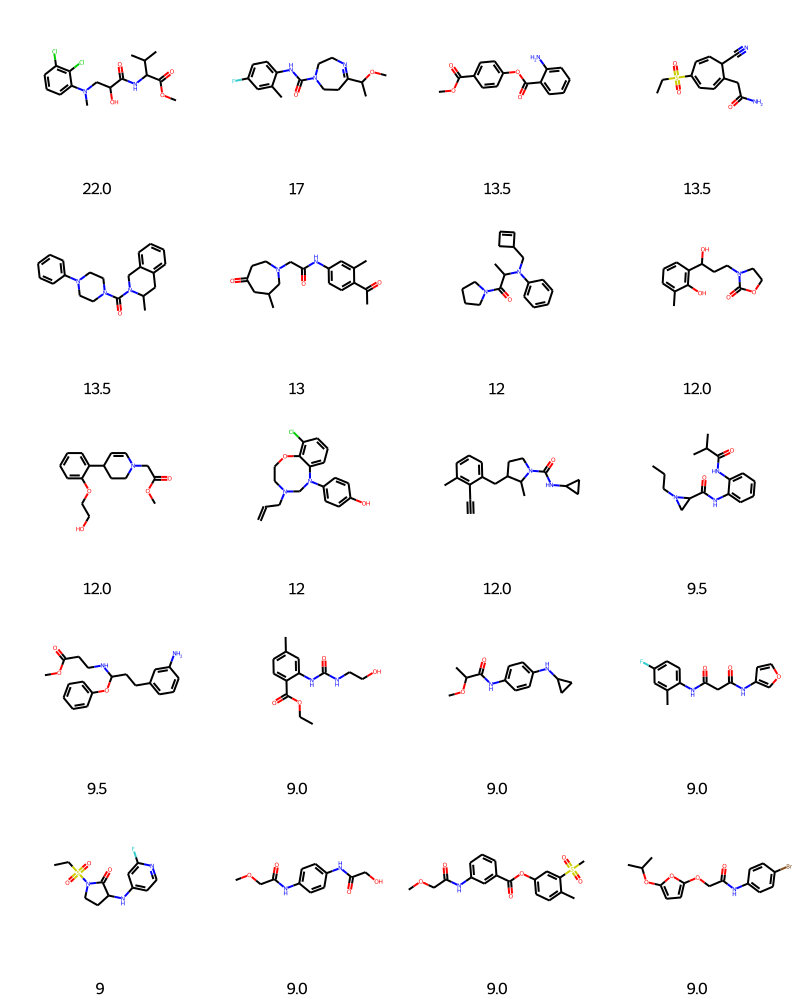

In [10]:
Draw.MolsToGridImage([get_mol(sm) for sm in smiles_list],molsPerRow=4,subImgSize=(200,200),legends=[str(fps_som.som_reward(s)) for s in smiles_list], returnPNG=False)